In [1]:
# importing libraries.....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from tensorflow.keras.layers import TextVectorization,Embedding
import warnings
import random
from tensorflow.keras import layers
import string

In [2]:
# filter warnings.
warnings.filterwarnings("ignore")

In [3]:
# for downloading data.....
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
# !ls pubmed-rct

The goal of this model is to classify the sentences which appear in the sequences, like what role each sentences serve in the abstract

## What we're going to do:
    ~ Download Dataset
    ~ Writing Preprocessing Function to prepare data for modelling
    ~ Setup Series of Model Experiment
    ~ Make MultiModel Model
    ~ Make Prediction

In [4]:
# check out the files in the dataset
# !ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

Well we've three files there first one is for development set which is another name for validation data while 2nd and 3rd files contain data for testing and training respectively.

In [5]:
# check all filenames in the directory....
# data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
# filenames = [data_dir + fname for fname in os.listdir(data_dir)]
# filenames

In [6]:
!ls

README.md     dev.txt       test.txt
SkimLit.ipynb pubmed-rct    train.txt


## Preprocessing Data:

In [7]:
# let's make a function that will preprocess the data
def get_lines(fname):
    """
    reads the filename and return the lines of the text as a list
    """
    with open(fname,"r") as file:
        return file.readlines()

In [8]:
!ls

README.md     dev.txt       test.txt
SkimLit.ipynb pubmed-rct    train.txt


In [9]:
# get the lines 
train_lines = get_lines("train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [10]:
train_lines[:2]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n']

In [11]:
def preprocess_text(filename):
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [12]:
# get the data from files and preprocess it
train_samples = preprocess_text("train.txt")
val_samples = preprocess_text("dev.txt")
test_samples = preprocess_text("test.txt")

# checking the length of each sample
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [13]:
# convert them into pandas data-frame
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

# check out the head of train df
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [14]:
# checking the destribution of the target values...
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

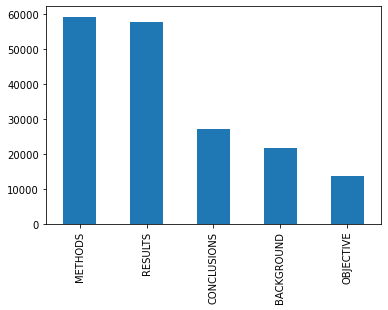

In [15]:
# let's visulize it...
train_df["target"].value_counts().plot(kind="bar");

In [16]:
# get the sentences from data-frame line X values
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

# viewing couple of few lines...
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [17]:
# get the "Target" Y values and convert them into One-Hot-Encoder
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_df["target"].to_numpy())
test_labels = encoder.transform(test_df["target"].to_numpy())
val_labels = encoder.transform(val_df["target"].to_numpy())

train_labels

array([3, 2, 2, ..., 4, 1, 1])

In [34]:
print(encoder.classes_)
num_classes = len(encoder.classes_)
num_classes

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


5

## Model Experiments:

## Model 0 : BaseLine Model

our first baseline model will be scikit-learn Naive Bayes Model.

In [19]:
# baseline model
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("model",MultinomialNB())
])

# fitting the model on data....
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('model', MultinomialNB())])

In [20]:
# evaluate baseline model...
model_0.score(val_sentences,val_labels) * 100

72.1832384482987

## Model Perfomance Evaluation


In [21]:
# let's make a function that will evaluate our model performance
def calculate_results(y_true,y_pred):
    """
    This function will take two parameters and will return the Model Accuracy,Precision,Recall and Support.
    """
    model_accuracy = accuracy_score(y_true,y_pred) * 100
    model_precision,model_recall,model_fscore,_ = precision_recall_fscore_support(y_true,y_pred,
                                                                                  average="weighted")
    results = {"Accuracy" : model_accuracy,
              "Precision" : model_precision,
              "Recall" : model_recall,
              "Fscore" : model_fscore}
    return results

In [22]:
# make prediction on baseline model
baseline_pred = model_0.predict(val_sentences)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# let's calculate the results...
baseline_results = calculate_results(val_labels,baseline_pred)
baseline_results

{'Accuracy': 72.1832384482987,
 'Precision': 0.7186466952323352,
 'Recall': 0.7218323844829869,
 'Fscore': 0.6989250353450294}

Wow! look like our model has achieved accuracy of 72.1% not bad.

## Prepare data for deep learning models...

We've to convert our data into a shape that is suitable for deep learning models.
First we'll tokenize our data and then embbed it and finally feed into the model.

In [24]:
# let's find out the average sentence length
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_len = sum(sent_len)/len(train_sentences)
avg_len

26.338269273494777

In [25]:
# checking the length for output_sequence
output_seq_len = int(np.percentile(sent_len,95))
output_seq_len

55

In [26]:
# max tokens...
max_tokens = 68000

# make first tokenizer layer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length = output_seq_len,)

# adapt it to the train data...
text_vectorizer.adapt(train_sentences)

Metal device set to: Apple M1


2022-08-19 22:56:33.048032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-19 22:56:33.048186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-19 22:56:33.765214: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-19 22:56:33.816427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [27]:
# check out the vectorizer
random_sentence = random.choice(train_sentences)
print(f"Original Sentence : {random_sentence}\n")
print(f"Vectorizer Sentence : {text_vectorizer([random_sentence])}")

Original Sentence : clinicaltrials.gov nct@ http://clinicaltrials.gov/ct@/show/nct@ .

Vectorizer Sentence : [[  275   176 11581     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [28]:
# find out the vocabulary from data...
vocab = text_vectorizer.get_vocabulary()
print(f"Total Words in the Vocabulary : {len(vocab)}\n")
print(f"Top five words :\n {vocab[:5]}\n")
print(f"Bottom five words : \n {vocab[-5:]}")

Total Words in the Vocabulary : 64841

Top five words :
 ['', '[UNK]', 'the', 'and', 'of']

Bottom five words : 
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [29]:
# Create Embedd Layer for richer representation for our token numbers...
embed_layer = Embedding(input_dim = len(vocab),
                       output_dim =128,
                       embeddings_initializer="uniform",
                       input_length=55,
                       name="Default_Embedding")

# check out the Embedding layer
random_sentence = random.choice(train_sentences)
print(f"Original Sentence : \n{random_sentence}\n")
print(f"Embedd Sentence : \n {embed_layer(text_vectorizer([random_sentence]))}")

Original Sentence : 
this is particularly valuable in situations involving complex visual subject matters , typical in clinical practice .

Embedd Sentence : 
 [[[ 0.01854812  0.03406577  0.03569676 ...  0.04980786 -0.01408248
    0.01847013]
  [-0.00635862  0.03439102 -0.04105362 ...  0.04345198  0.00032137
    0.00385853]
  [ 0.02368069  0.02760288 -0.0249552  ... -0.0257163   0.04944159
   -0.04412895]
  ...
  [ 0.02198042 -0.02677277 -0.04756169 ...  0.04956089 -0.01161468
   -0.0484657 ]
  [ 0.02198042 -0.02677277 -0.04756169 ...  0.04956089 -0.01161468
   -0.0484657 ]
  [ 0.02198042 -0.02677277 -0.04756169 ...  0.04956089 -0.01161468
   -0.0484657 ]]]


In [30]:
# create dataset as fast as possible 
# let's convert our data into tensors...
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))

In [31]:
# now convert them into the batches and prefetch for fast load on GPU
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [32]:
# check out the train dataset
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model 1 : Cov1D

In [35]:
# the first model we're going to build is 1-dimensional Convolutional Neural Network...

# create input layer
inputs = layers.Input(shape = (1,),dtype=tf.string)

# text vectorization layer...
x = text_vectorizer(inputs)

# Embedd layer...
x = embed_layer(x)

# conv1d layer
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(x)

# add the average pool layer....
x = layers.GlobalAveragePooling1D()(x)

# the output layer
outputs = layers.Dense(num_classes,activation="softmax")(x)

# build the model...
model_1 = tf.keras.Model(inputs,outputs,name="Conv1D_Model")

# compile the model
model_1.compile(loss="sparse_categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])
# model_1 summary
model_1.summary()

Model: "Conv1D_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 Default_Embedding (Embeddin  (None, 55, 128)          8299648   
 g)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                      

In [36]:
# fitting the model to data.....
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                       epochs=3,
                       validation_data=val_dataset,
                       validation_steps = int(0.1 * len(val_dataset)),
                       callbacks =[tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/3
  1/562 [..............................] - ETA: 4:01 - loss: 1.6093 - accuracy: 0.0625

2022-08-19 22:58:36.598745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


561/562 [============================>.] - ETA: 0s - loss: 0.9177 - accuracy: 0.6369

2022-08-19 22:58:55.404192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


562/562 [==============================] - 19s 34ms/step - loss: 0.9169 - accuracy: 0.6373 - val_loss: 0.6828 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 18s 32ms/step - loss: 0.6540 - accuracy: 0.7581 - val_loss: 0.6290 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.6144 - accuracy: 0.7741 - val_loss: 0.5945 - val_accuracy: 0.7866


In [37]:
# time to make prediction with our model
model_1_probs = model_1.predict(val_dataset)
model_1_probs

 67/945 [=>............................] - ETA: 2s

2022-08-19 22:59:31.585312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


945/945 [==============================] - 3s 3ms/step


array([[4.2674640e-01, 1.4814913e-01, 6.9188677e-02, 3.2962820e-01,
        2.6287546e-02],
       [4.8393324e-01, 2.2787191e-01, 1.2383969e-02, 2.6750058e-01,
        8.3103646e-03],
       [1.5913843e-01, 4.6922504e-03, 1.3429127e-03, 8.3478421e-01,
        4.2152493e-05],
       ...,
       [4.7417516e-06, 7.2817388e-04, 7.2644791e-04, 4.8627176e-06,
        9.9853575e-01],
       [5.6012433e-02, 4.9329013e-01, 8.7086372e-02, 5.7346497e-02,
        3.0626446e-01],
       [1.7591362e-01, 6.8200552e-01, 6.2432874e-02, 3.9306335e-02,
        4.0341672e-02]], dtype=float32)

In [38]:
# convert proeb probs into labels
model_1_preds = tf.argmax(model_1_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [39]:
# evaluate our model performance....
model_1_results = calculate_results(val_labels,model_1_preds)
model_1_results

{'Accuracy': 78.7733350986363,
 'Precision': 0.7840981186048689,
 'Recall': 0.787733350986363,
 'Fscore': 0.7853102395179401}

## Model 2 : Conv1D with Character Embeddings...

In [40]:
# make a function that will split sentences into characters...
def split_sentences(sentence):
    return " ".join(list(sentence))

In [41]:
# split sentences into characters....
train_char = [split_sentences(sentence) for sentence in train_sentences]
val_char = [split_sentences(sentence) for sentence in val_sentences]
test_char = [split_sentences(sentence) for sentence in test_sentences]

print(train_char[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [42]:
# average character length....
char_len = [len(sentence) for sentence in train_sentences]
mean_char = np.mean(char_len)
mean_char

149.3662574983337

In [43]:
output_seq_len = int(np.percentile(char_len,95))
output_seq_len 

290

In [44]:
# create char-level vectorization...
alp = string.ascii_lowercase + string.digits + string.printable

num_tokens= len(alp) + 2 # for space and OOV objects
char_token = TextVectorization(max_tokens = num_tokens,
                              output_sequence_length = output_seq_len,
                              standardize = "lower_and_strip_punctuation",
                              name= "Char_Vectorization")

# adapt to data...
char_token.adapt(train_char)

2022-08-19 22:59:36.871365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [45]:
# let's check it out....
random_char = random.choice(train_char)
print(f"Original Text : \n {random_char}\n")
print(f"Vectorizer Text : \n{char_token([random_char])}")

Original Text : 
 t h i s   p r o t o c o l   f o r   a   r a n d o m i z e d   c o n t r o l l e d   s t u d y   i n v e s t i g a t i n g   t h e   i m p a c t   o f   t h e   t i m i n g   o f   r e n a l   r e p l a c e m e n t   t h e r a p y   i n i t i a t i o n   s h o u l d   p r o v i d e   a n   a n s w e r   t o   a   k e y   q u e s t i o n   f o r   t h e   m a n a g e m e n t   o f   p a t i e n t s   w i t h   a c u t e   k i d n e y   i n j u r y   i n   t h e   c o n t e x t   o f   s e p t i c   s h o c k   ,   f o r   w h o m   t h e   m o r t a l i t y   r a t e   r e m a i n s   c l o s e   t o   @   %   d e s p i t e   i m p r o v e d   u n d e r s t a n d i n g   o f   p h y s i o p a t h o l o g y   a n d   r e c e n t   t h e r a p e u t i c   a d v a n c e s   .

Vectorizer Text : 
[[ 3 13  4  9 14  8  7  3  7 11  7 12 17  7  8  5  8  5  6 10  7 15  4 25
   2 10 11  7  6  3  8  7 12 12  2 10  9  3 16 10 19  4  6 21  2  9  3  4
  18  5  3  4  6 18  3 13  2  4 

In [46]:
# find out the vocabulary in the data.....
vocab_char = char_token.get_vocabulary()
print(f"Total different characters in vocab : {len(vocab_char)}\n")
print(f"Top 5 chars : {vocab_char[:5]}\n")
print(f"Bottom 5 chars : {vocab_char[-5:]}")

Total different characters in vocab : 28

Top 5 chars : ['', '[UNK]', 'e', 't', 'i']

Bottom 5 chars : ['k', 'x', 'z', 'q', 'j']


### Character level embedding...

In [47]:
char_embedd = Embedding(input_dim = num_tokens,
                       output_dim = 25,
                       mask_zero = False,
                       name= "char_Embed")

# let'check it out...
random_char = random.choice(train_char)
print(f"Original Text : \n {random_char}\n")
print(f"Vectorizer Text : \n{char_embedd(char_token([random_char]))}")

Original Text : 
 v i s u a l   a t l a s   a n d   c o n s e n s u s   t r e a t m e n t   g u i d e l i n e   u s a g e   i n   t h e   d e v e l o p m e n t   o f   r e c t a l   c a n c e r   i m r t   t r e a t m e n t   p l a n s   r e d u c e d   t h e   i n t e r - o b s e r v e r   r a d i o b i o l o g i c a l   v a r i a t i o n   ,   w i t h   c l i n i c a l l y   r e l e v a n t   t c p   a l t e r a t i o n   f o r   c t v   a n d   p t v   v o l u m e s   .

Vectorizer Text : 
[[[ 0.02302421  0.04897788 -0.01751237 ... -0.03485013  0.02618638
   -0.02471949]
  [ 0.04320708  0.00625777 -0.00241963 ... -0.04911428 -0.00754761
   -0.04169189]
  [ 0.03426358  0.04542596  0.04011219 ...  0.00630441 -0.04588494
    0.02532015]
  ...
  [-0.0188207   0.03263413  0.01849456 ... -0.03177612  0.04988373
   -0.01304941]
  [-0.0188207   0.03263413  0.01849456 ... -0.03177612  0.04988373
   -0.01304941]
  [-0.0188207   0.03263413  0.01849456 ... -0.03177612  0.04988373
   -0.01304941

In [48]:
# let's build the char-level Conv1D Model....
inputs = layers.Input(shape=(1,),dtype="string")
x = char_token(inputs) # passing the input to char vectorizer

# passing the char vectorizer to embedding...
x = char_embedd(x)

# passing the embedding to conv layer
x = layers.Conv1D(64,kernel_size=5,activation="relu",padding="same")(x)

# passing the conv layer to pool layer
x = layers.GlobalAveragePooling1D()(x)

# outputs
outputs = layers.Dense(num_classes,activation="softmax")(x)

# model building...
model_2 = tf.keras.Model(inputs,outputs)


In [49]:
# compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [50]:
# model summary
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 Char_Vectorization (TextVec  (None, 290)              0         
 torization)                                                     
                                                                 
 char_Embed (Embedding)      (None, 290, 25)           3450      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325   

In [51]:
# create char tensor data-sets..
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char,train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char,val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [52]:
# fitting the model to data...
history_2 = model_2.fit(train_char_dataset,
                       epochs =3,
                       steps_per_epoch = int(0.1 * len(train_char)),
                       validation_data = val_char_dataset,
                       validation_steps = int(0.1 * len(val_char)))

Epoch 1/3
    3/18004 [..............................] - ETA: 9:32 - loss: 1.6080 - accuracy: 0.2083   

2022-08-19 22:59:41.731329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5627/18004 [========>.....................] - ETA: 5:44 - loss: 1.3074 - accuracy: 0.4516WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 54012 batches). You may need to use the repeat() function when building your dataset.


2022-08-19 23:02:18.738406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18004/18004 [==============================] - 162s 9ms/step - loss: 1.3074 - accuracy: 0.4516 - val_loss: 1.2403 - val_accuracy: 0.4883


In [53]:
# let's make prediction and calculate the results...
model_2_results = calculate_results(val_labels,tf.argmax(model_2.predict(val_char_dataset),axis=1))
model_2_results

 47/945 [>.............................] - ETA: 3s

2022-08-19 23:02:23.274929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


945/945 [==============================] - 5s 5ms/step


{'Accuracy': 48.82828015358136,
 'Precision': 0.4444318962929611,
 'Recall': 0.4882828015358136,
 'Fscore': 0.44412241465253566}

In [54]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 Char_Vectorization (TextVec  (None, 290)              0         
 torization)                                                     
                                                                 
 char_Embed (Embedding)      (None, 290, 25)           3450      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325   

In [61]:
# compare results....
all_model = pd.DataFrame({
    "BaseLine" : baseline_results,
    "Conv1D" : model_1_results,
    "Char_Model" : model_2_results
})

all_model = all_model.transpose()
all_model

,Accuracy,Precision,Recall,Fscore
BaseLine,72.183238,0.718647,0.721832,0.698925
Conv1D,78.773335,0.784098,0.787733,0.785310
Char_Model,48.828280,0.444432,0.488283,0.444122


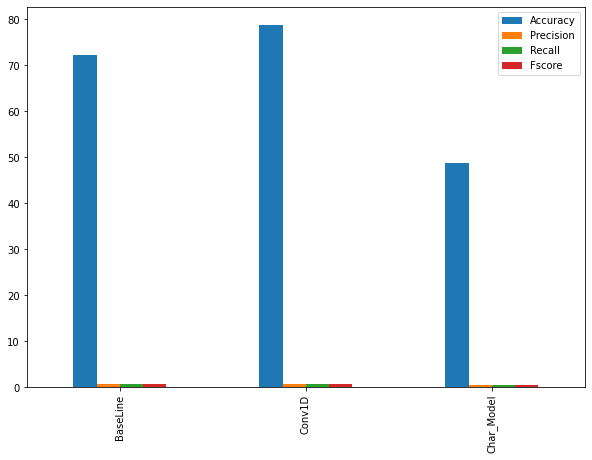

In [62]:
# plot and compare all of the model results....
all_model.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

In [63]:
# make predictions with char model...
preds = tf.argmax(model_2.predict(test_dataset),axis=1)
preds

942/942 [==============================] - 5s 5ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([4, 4, 4, ..., 4, 4, 4])>

In [64]:
results = calculate_results(test_labels,preds)
results

{'Accuracy': 32.407499585199936,
 'Precision': 0.2803063236555915,
 'Recall': 0.32407499585199934,
 'Fscore': 0.1629559788998415}